<a href="https://colab.research.google.com/github/savindu29/NeuralNet/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch-summary

In [3]:
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data

In [4]:
import os

# Mount Google Drive (only for Colab users)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root_save_path = "/content/drive/MyDrive/Preprocessed_Data"
# Define separate paths for NumPy and PyTorch tensors
numpy_save_path = os.path.join(root_save_path, "numpy_data")
torch_save_path = os.path.join(root_save_path, "torch_data")

In [24]:
# Load NumPy arrays
X_train = np.load(os.path.join(numpy_save_path, "X_train.npy"))
X_test = np.load(os.path.join(numpy_save_path, "X_test.npy"))
y_train = np.load(os.path.join(numpy_save_path, "y_train.npy"))
y_test = np.load(os.path.join(numpy_save_path, "y_test.npy"))

# Print loaded shapes
print("Loaded NumPy Data:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add missing dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create Tensor Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Print dataset sizes
print("\nProcessed PyTorch Tensors:")
print("X_train shape:", X_train_tensor.size())
print("X_test shape:", X_test_tensor.size())
print("y_train shape:", y_train_tensor.size())
print("y_test shape:", y_test_tensor.size())

print("✅ Data successfully loaded and processed!")


Loaded NumPy Data:
X_train shape: (4147, 22, 1001)
X_test shape: (1037, 22, 1001)
y_train shape: (4147,)
y_test shape: (1037,)

Processed PyTorch Tensors:
X_train shape: torch.Size([4147, 1, 22, 1001])
X_test shape: torch.Size([1037, 1, 22, 1001])
y_train shape: torch.Size([4147])
y_test shape: torch.Size([1037])
✅ Data successfully loaded and processed!


# Model Training class

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

class TrainModel():
    def __init__(self, patience=10):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loss = []  # To store training loss for plotting
        self.train_accuracy = []  # To store training accuracy for plotting
        self.val_loss = []  # To store validation loss for plotting
        self.val_accuracy = []  # To store validation accuracy for plotting

    def train_model(self, model, train_dataset, validation_dataset=None, learning_rate=0.001, batch_size=64, epochs=500):
        # Send the model to the device (GPU or CPU)
        model = model.to(self.device)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize the ReduceLROnPlateau scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

        # Create DataLoader for training data
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Track highest accuracy and patience for Early Stopping
        highest_train_accuracy = 0.0
        best_epoch = 0
        early_stopping_counter = 0

        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            running_loss = 0.0
            correct = 0
            total = 0

            # Training loop
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()  # Zero the gradients

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Track running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total

            # Update the learning rate scheduler based on training loss
            scheduler.step(epoch_loss)  # Reduce learning rate if loss doesn't improve

            # Collect the data for plotting
            self.train_loss.append(epoch_loss)
            self.train_accuracy.append(epoch_accuracy)

            # Validation step
            if validation_dataset is not None:
                val_loss, val_accuracy = self.validate_model(model, validation_dataset, criterion)
                self.val_loss.append(val_loss)
                self.val_accuracy.append(val_accuracy)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {(epoch_accuracy*100):.2f}%, "
                      f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")
            else:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

            # Early stopping
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
                best_epoch = epoch
            #     early_stopping_counter = 0  # Reset the early stopping counter
            # else:
            #     early_stopping_counter += 1  # Increment the counter if no improvement

            # # Check for early stopping
            # if early_stopping_counter >= self.patience:
            #     print("Early stopping triggered")
            #     break

        # Calculate the average training loss over all epochs
        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving the trained model
        torch.save(model.state_dict(), 'trained_model.pth')

        # Plotting the results
        self.plot_results()

        return model

    def validate_model(self, model, validation_dataset, criterion):
        """Validation step to monitor the validation performance."""
        model.eval()  # Set the model to evaluation mode
        val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # No need to track gradients during validation
            for inputs, labels in val_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(validation_dataset)
        val_accuracy = correct_val / total_val
        return val_loss, val_accuracy

    def plot_results(self):
        """Plot training and validation loss and accuracy."""
        epochs = len(self.train_loss)

        plt.figure(figsize=(10, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), self.train_accuracy, label='accuracy', color='blue')
        plt.plot(range(epochs), self.val_accuracy, label='val_accuracy', color='blue', linestyle='dotted')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), self.train_loss, label='loss', color='red')
        plt.plot(range(epochs), self.val_loss, label='val_loss', color='red', linestyle='dotted')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (cross-entropy)')
        plt.title('Loss vs Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Model Evaluation class

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")

        return accuracy, y_true, y_pred

    def print_classification_report(self, y_true, y_pred, target_names):
        print("Classification Report:\n")
        report = classification_report(y_true, y_pred, target_names=target_names)
        print(report)

    def plot_confusion_matrix(self, y_true, y_pred, classes):
        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')  # 'd' ensures actual counts, not percentages
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()


    def plot_metrics(self, hist):
        # Plot accuracy and loss
        fig, ax = plt.subplots()
        ax.plot(hist['accuracy'], color='b', label='accuracy')
        ax.plot(hist['val_accuracy'], linestyle=':', color='b', label='val_accuracy')
        ax.set_ylabel("Accuracy", color='b')
        ax.set_ylim([0, 1])

        ax2 = ax.twinx()
        ax2.plot(hist['loss'], color='r', label='loss')
        ax2.plot(hist['val_loss'], linestyle=':', color='r', label='val_loss')
        ax2.set_ylabel("Loss (cross-entropy)", color='r')

        fig.legend(loc='best')
        plt.title('Accuracy and Loss over Epochs')
        plt.show()

    def plot_classification_metrics(self, y_true, y_pred, target_names):
        # Classification report and metrics
        report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()

        # Plot metrics
        report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 7))
        plt.title('Classification Report Metrics')
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Cohen's Kappa score
        kappa = cohen_kappa_score(y_true, y_pred)
        print(f"Cohen's Kappa: {kappa:.4f}")






In [8]:
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=22, classes=4, time_points=1001, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Summary

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
input_size = (1, 22, 1001)
eegnet_model = EEGNetModel(chans=22, classes=4, time_points=1001, temp_kernel=64,
                           f1=32, f2=64, dropout_rate=0.3).to(device)

summary(eegnet_model, input_size)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 22, 1001]        --
|    └─Conv2d: 2-1                       [-1, 32, 22, 1001]        2,048
|    └─BatchNorm2d: 2-2                  [-1, 32, 22, 1001]        64
├─Sequential: 1-2                        [-1, 64, 1, 125]          --
|    └─Conv2d: 2-3                       [-1, 64, 1, 1001]         1,408
|    └─BatchNorm2d: 2-4                  [-1, 64, 1, 1001]         128
|    └─ELU: 2-5                          [-1, 64, 1, 1001]         --
|    └─AvgPool2d: 2-6                    [-1, 64, 1, 125]          --
|    └─Dropout: 2-7                      [-1, 64, 1, 125]          --
├─Sequential: 1-3                        [-1, 64, 1, 7]            --
|    └─Conv2d: 2-8                       [-1, 64, 1, 125]          1,024
|    └─Conv2d: 2-9                       [-1, 64, 1, 125]          4,096
|    └─BatchNorm2d: 2-10                 [-1, 64, 1, 125]          128
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 22, 1001]        --
|    └─Conv2d: 2-1                       [-1, 32, 22, 1001]        2,048
|    └─BatchNorm2d: 2-2                  [-1, 32, 22, 1001]        64
├─Sequential: 1-2                        [-1, 64, 1, 125]          --
|    └─Conv2d: 2-3                       [-1, 64, 1, 1001]         1,408
|    └─BatchNorm2d: 2-4                  [-1, 64, 1, 1001]         128
|    └─ELU: 2-5                          [-1, 64, 1, 1001]         --
|    └─AvgPool2d: 2-6                    [-1, 64, 1, 125]          --
|    └─Dropout: 2-7                      [-1, 64, 1, 125]          --
├─Sequential: 1-3                        [-1, 64, 1, 7]            --
|    └─Conv2d: 2-8                       [-1, 64, 1, 125]          1,024
|    └─Conv2d: 2-9                       [-1, 64, 1, 125]          4,096
|    └─BatchNorm2d: 2-10                 [-1, 64, 1, 125]          128
|

# Train the model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/300, Train Loss: 1.3564, Train Accuracy: 32.36%, Validation Loss: 1.2972, Validation Accuracy: 39.63%
Epoch 2/300, Train Loss: 1.2565, Train Accuracy: 42.25%, Validation Loss: 1.1710, Validation Accuracy: 49.18%
Epoch 3/300, Train Loss: 1.1679, Train Accuracy: 46.80%, Validation Loss: 1.1119, Validation Accuracy: 50.24%
Epoch 4/300, Train Loss: 1.1334, Train Accuracy: 49.77%, Validation Loss: 1.0677, Validation Accuracy: 54.10%
Epoch 5/300, Train Loss: 1.0917, Train Accuracy: 51.00%, Validation Loss: 1.0653, Validation Accuracy: 53.04%
Epoch 6/300, Train Loss: 1.0724, Train Accuracy: 53.65%, Validation Loss: 1.0413, Validation Accuracy: 54.29%
Epoch 7/300, Train Loss: 1.0356, Train Accuracy: 54.55%, Validation Loss: 0.9831, Validation Accuracy: 57.96%
Epoch 8/300, Train Loss: 1.0263, Train Accuracy: 55.08%, Validation Loss: 0.9714, Validation Accuracy: 58.53%
Epoch 9/300, Train Loss: 1.0132, Train Accuracy: 55.92%, Validation Loss: 0.9738, Validation Accuracy: 57.57%
Epoch 10/3

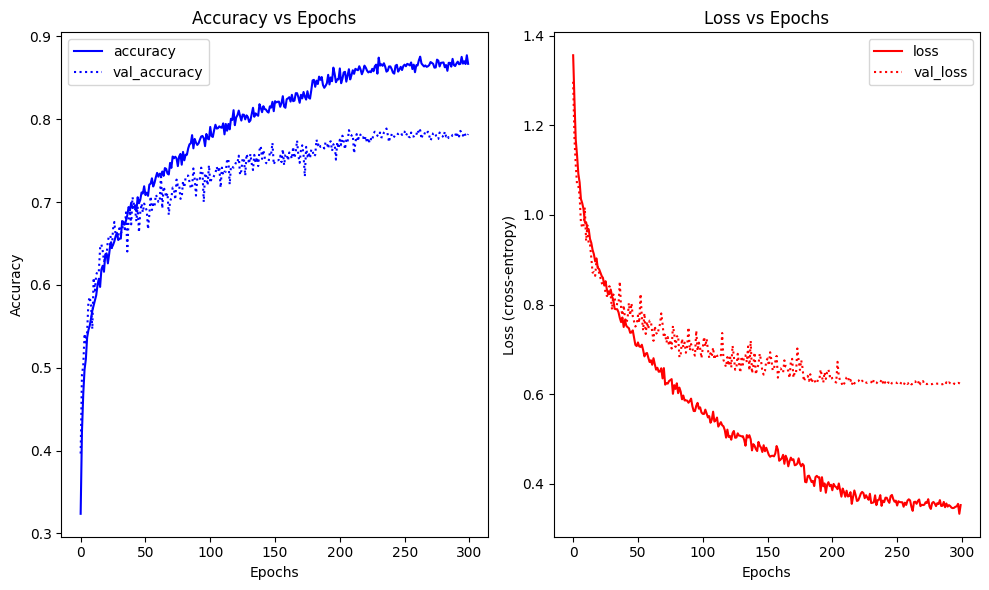

In [25]:
# Training Hyperparameters
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel(patience=10)
trained_eegnet = trainer.train_model(eegnet_model, train_dataset, validation_dataset=test_dataset,learning_rate=LEARNING_RATE,
                                   batch_size=BATCH_SIZE, epochs=EPOCHS)
torch.save(trained_eegnet.state_dict(), 'eegnet_model.pth')

In [27]:
classes_list = ['Left', 'Right', 'Foot', 'Tongue']
eval_model = EvalModel(trained_eegnet)


In [28]:
# Testing the model
accuracy, y_true, y_pred = eval_model.test_model(test_dataset)

/------------------------------/
Test Accuracy: 78.21%
/------------------------------/


In [29]:
# Classification report
eval_model.print_classification_report(y_true, y_pred, classes_list)

Classification Report:

              precision    recall  f1-score   support

        Left       0.77      0.82      0.80       259
       Right       0.81      0.77      0.79       259
        Foot       0.73      0.73      0.73       260
      Tongue       0.82      0.80      0.81       259

    accuracy                           0.78      1037
   macro avg       0.78      0.78      0.78      1037
weighted avg       0.78      0.78      0.78      1037



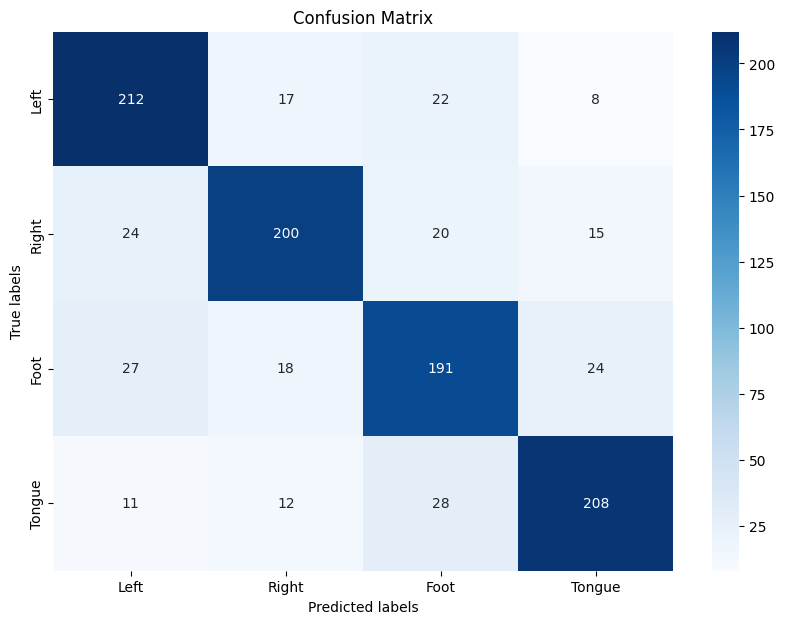

In [30]:
# Plot confusion matrix
eval_model.plot_confusion_matrix(y_true, y_pred, classes_list)

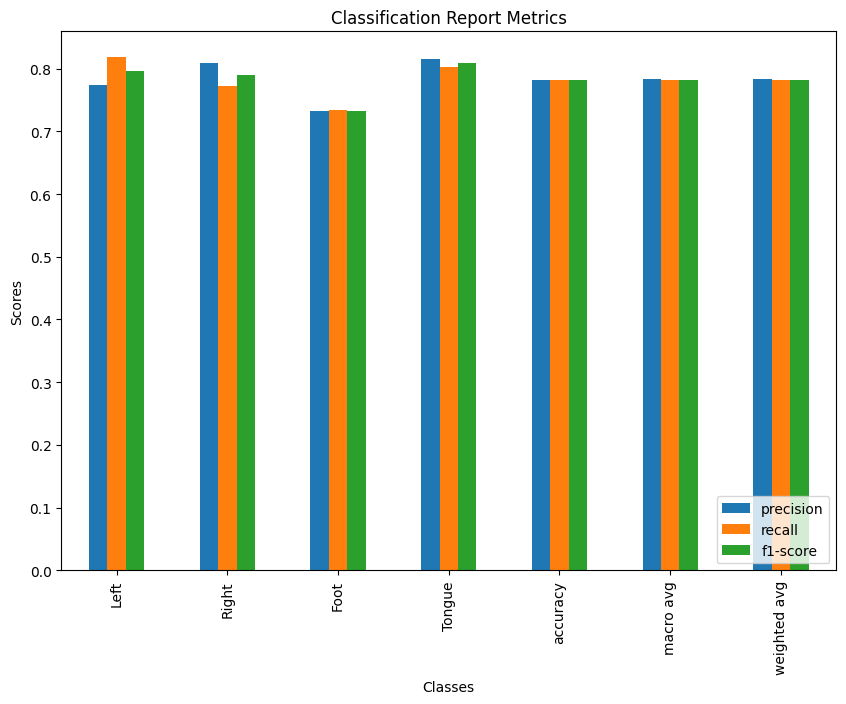

Cohen's Kappa: 0.7094


In [31]:
# Plot classification metrics like precision, recall, and f1-score
eval_model.plot_classification_metrics(y_true, y_pred, classes_list)